In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/M1_S2/ML/ProjetML
import numpy as np
from mltools import *
import copy as cp

Mounted at /content/drive
/content/drive/MyDrive/M1_S2/ML/ProjetML


# Les utils

In [ ]:
import numpy as np
#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


def plot_data(data,labels=None):
    """
    Affiche des donnees 2D
    :param data: matrice des donnees 2d
    :param labels: vecteur des labels (discrets)
    :return:
    """
    if labels is not None:
        labels = labels.reshape(-1)
    cols,marks = ["red", "green", "blue", "orange", "black", "cyan"],[".","+","*","o","x","^"]
    if labels is None:
        plt.scatter(data[:,0],data[:,1],marker="x")
        return
    for i,l in enumerate(sorted(list(set(labels.flatten())))):
        plt.scatter(data[labels==l,0],data[labels==l,1],c=cols[i],marker=marks[i])

def plot_frontiere(data,f,step=20):
    """ Trace un graphe de la frontiere de decision de f
    :param data: donnees
    :param f: fonction de decision
    :param step: pas de la grille
    :return:
    """
    grid,x,y=make_grid(data=data,step=step)
    plt.contourf(x,y,f(grid).reshape(x.shape),colors=('gray','blue'),levels=[-1,0,1])

def make_grid(data=None,xmin=-5,xmax=5,ymin=-5,ymax=5,step=20):
    """ Cree une grille sous forme de matrice 2d de la liste des points
    :param data: pour calcluler les bornes du graphe
    :param xmin: si pas data, alors bornes du graphe
    :param xmax:
    :param ymin:
    :param ymax:
    :param step: pas de la grille
    :return: une matrice 2d contenant les points de la grille
    """
    if data is not None:
        xmax, xmin, ymax, ymin = np.max(data[:,0]),  np.min(data[:,0]), np.max(data[:,1]), np.min(data[:,1])
    x, y =np.meshgrid(np.arange(xmin,xmax,(xmax-xmin)*1./step), np.arange(ymin,ymax,(ymax-ymin)*1./step))
    grid=np.c_[x.ravel(),y.ravel()]
    return grid, x, y

def gen_arti(centerx=1,centery=1,sigma=0.1,nbex=1000,data_type=0,epsilon=0.02):
    """ Generateur de donnees,
        :param centerx: centre des gaussiennes
        :param centery:
        :param sigma: des gaussiennes
        :param nbex: nombre d'exemples
        :param data_type: 0: melange 2 gaussiennes, 1: melange 4 gaussiennes, 2:echequier
        :param epsilon: bruit dans les donnees
        :return: data matrice 2d des donnnes,y etiquette des donnnees
    """
    if data_type==0:
         #melange de 2 gaussiennes
         xpos=np.random.multivariate_normal([centerx,centerx],np.diag([sigma,sigma]),nbex//2)
         xneg=np.random.multivariate_normal([-centerx,-centerx],np.diag([sigma,sigma]),nbex//2)
         data=np.vstack((xpos,xneg))
         y=np.hstack((np.ones(nbex//2),-np.ones(nbex//2)))
    if data_type==1:
        #melange de 4 gaussiennes
        xpos=np.vstack((np.random.multivariate_normal([centerx,centerx],np.diag([sigma,sigma]),nbex//4),np.random.multivariate_normal([-centerx,-centerx],np.diag([sigma,sigma]),nbex//4)))
        xneg=np.vstack((np.random.multivariate_normal([-centerx,centerx],np.diag([sigma,sigma]),nbex//4),np.random.multivariate_normal([centerx,-centerx],np.diag([sigma,sigma]),nbex//4)))
        data=np.vstack((xpos,xneg))
        y=np.hstack((np.ones(nbex//2),-np.ones(nbex//2)))

    if data_type==2:
        #echiquier
        data=np.reshape(np.random.uniform(-4,4,2*nbex),(nbex,2))
        y=np.ceil(data[:,0])+np.ceil(data[:,1])
        y=2*(y % 2)-1
    # un peu de bruit
    data[:,0]+=np.random.normal(0,epsilon,nbex)
    data[:,1]+=np.random.normal(0,epsilon,nbex)
    # on mélange les données
    idx = np.random.permutation((range(y.size)))
    data=data[idx,:]
    y=y[idx]
    return data,y.reshape(-1, 1)

def load(filename):
    f=open(filename,'r')
    s = f.readline() # virer la premiere ligne
    X = np.array([[float(d) for d in lig.split()] for lig in f if len(lig)>10])
    Y = X[:,0] # premiere colonne
    X = X[:,1:]
    f.close()
    return X,Y

# Fonctions coût

In [ ]:
class Loss(object):
    def forward(self, y, yhat):
        pass

    def backward(self, y, yhat):
        pass

class MSELoss(Loss):
    def forward(self, y, yhat):
        """ Calculer le coût en fonction des 2 entrées
        """
        return np.linalg.norm(y-yhat, axis=1)**2

    def backward(self, y, yhat):
        """ Calculer le gradient du cout par rapport yhat
        """
        return -2*(y-yhat)

def logsoftmax(y):
  return np.exp(y)/np.sum(np.exp(y), axis = 1)[:, np.newaxis]

class SMCELoss(Loss):
    def forward(self, y, yhat):
        """Coût cross-entropique
        y: indice de la classe à prédire, exp pour 1 exemple [0,0,0,1] -> classe 3
        y_hat: le vecteur de prédiction -> exp pour 1 exemple [0.1, 0.3, 0.4, 0.2]
        """
        #-yhat_y + log(sum_i(exp(yhat_i)))
        return -np.sum(y*yhat, axis = 1) + np.log(np.sum(np.exp(yhat), axis = 1))

    def backward(self, y, yhat):
        """ Calculer le gradient du cout par rapport yhat
        """
        exp_sum_exp = np.exp(yhat)/np.sum(np.exp(yhat), axis = 1)[:, np.newaxis] # exp/sum(exp(yhat_i))
        tmp_2 = np.where(y==1, -1, 0)
        return exp_sum_exp + tmp_2 # ou y = 1 -> -1


class BCELoss(Loss):
    def forward(self, y, yhat):
        """Coût cross-entropique binaire
        y: indice de la classe à prédire, exp pour 1 exemple [0,0,0,1] -> classe 3
        y_hat: le vecteur de prédiction -> exp pour 1 exemple [0.1, 0.3, 0.4, 0.2]
        """
        yhat = np.where(yhat == 0, 1e-9, yhat)
        yhat = np.where(yhat == 1, 0.999999999, yhat)
        return -(y*np.log(yhat) + (1-y)*np.log(1-yhat))

    def backward(self, y, yhat):
        """ Calculer le gradient du cout par rapport yhat
        """
        yhat = np.where(yhat == 0, 1e-9, yhat)
        yhat = np.where(yhat == 1, 0.999999999, yhat)
        return -(y/yhat + (y-1)/(1-yhat))

# Modules

In [ ]:
class Module(object):
    def __init__(self):
        self._parameters = None
        self._gradient = None

    def zero_grad(self):
        ## Annule gradient
        pass

    def forward(self, X):
        ## Calcule la passe forward
        pass

    def update_parameters(self, gradient_step=1e-3):
        ## Calcule la mise a jour des parametres selon le gradient calcule et le pas de gradient_step
        self._parameters -= gradient_step*self._gradient

    def backward_update_gradient(self, input, delta):
        ## Met a jour la valeur du gradient
        pass

    def backward_delta(self, input, delta):
        ## Calcul la derivee de l'erreur
        pass

class Linear(Module):
    def __init__(self, input, output):
        """ Une couche linéaire dans le réseau de neurones

        Args:
            input (int): le nombre d'entrées
            output (int): le nombre de sorties
        """
        super().__init__()
        self._parameters = np.random.randn(output, input) # W
        #self._parameters = np.random.randn(input, output)
        #print(self._parameters.shape)
        self._gradient = np.zeros_like(self._parameters)

    def zero_grad(self):
        """ Réinitialiser à 0 le gradient
        """
        self._gradient = np.zeros_like(self._parameters)
    
    def forward(self, X):
        """ calculer les sorties du module pour les entrées passées en paramètre 
        """
        return np.dot(X,self._parameters.T) # <x,w>
        #return np.dot(X,self._parameters)
    
    
    def update_parameters(self, gradient_step=1e-3):
        """ Mettre à jour les paramètres du module selon le gradient accumulé 
            jusqu’à son appel avec un pas de gradient_step
        """ 
        self._parameters -= gradient_step*self._gradient
        #self._parameters /= np.linalg.norm(self._parameters)
        self.zero_grad()
        
    def backward_update_gradient(self, input, delta):
        """ On est dans la couche h, calculer le gradient du coût par
            rapport aux paramètres et l’additionner à la variable _gradient
            - en fonction de l’entrée input et des δ de la couche suivante delta

        Args:
            input (array): z_h-1
            delta (_type_): _description_
        """
        #print(f"LIN MAJ GRAD input {input.shape} delta {delta.shape}")
        #print("BW_grad_Lin",delta.T.shape, input.shape)
        gradient = delta.T@input
        #print(gradient.shape)
        #print(self._gradient.shape)
        #gradient = np.dot(input.T, delta)
        # print(gradient.shape)
        # print(self._gradient.shape)
        self._gradient += gradient
        

    def backward_delta(self, input, delta):
        """ calculer le gradient du coût par rapport aux entrées 
            en fonction de l’entrée input et des deltas de la couche
            suivante delta
        """
        #print(f"LIN input {input.shape} delta {delta.shape} w {self._parameters.shape}")
        return np.dot(delta, self._parameters)
        #return np.dot(delta, self._parameters.T)
    

class TanH(Module): # (e(z)-e(-z)) / (e(z)+e(-z))
    def __init__(self):
        """ Une couche tanH dans le réseau de neurones
        """
        super().__init__()
        

    def zero_grad(self):
        """ Réinitialiser à 0 le gradient
        """
        pass
    
    def forward(self, X):
        """ calculer les sorties du module pour les entrées passées en paramètre 
        """
        return  np.tanh(X)
    
    
    def update_parameters(self, gradient_step=1e-3):
        """ Mettre à jour les paramètres du module selon le gradient accumulé 
            jusqu’à son appel avec un pas de gradient_step
        """ 
        pass
        
    def backward_update_gradient(self, input, delta):
        """ On est dans la couche h, calculer le gradient du coût par
            rapport aux paramètres et l’additionner à la variable _gradient
            - en fonction de l’entrée input et des δ de la couche suivante delta

        Args:
            input (array): z_h-1
            delta (_type_): _description_
        """
        pass
        

    def backward_delta(self, input, delta):
        """ calculer le gradient du coût par rapport aux entrées 
            en fonction de l’entrée input et des deltas de la couche
            suivante delta
        """
        #print(f"TANH input {input.shape} delta {delta.shape}")
        return delta * (1 - np.tanh(input) ** 2) 
    
class Sigmoide(Module): # 1 / (1+e(-z))
    def __init__(self):
        """ Une couche tanH dans le réseau de neurones
        """
        super().__init__()
        

    def zero_grad(self):
        """ Réinitialiser à 0 le gradient
        """
        pass
    
    def forward(self, X):
        """ calculer les sorties du module pour les entrées passées en paramètre 
        """
        #X_tmp = np.clip(X, -500,500)
        #return  1/(1+np.exp(-X_tmp))
        return  1/(1+np.exp(-X))
    
    def update_parameters(self, gradient_step=1e-3):
        """ Mettre à jour les paramètres du module selon le gradient accumulé 
            jusqu’à son appel avec un pas de gradient_step
        """ 
        pass
        
    def backward_update_gradient(self, input, delta):
        """ On est dans la couche h, calculer le gradient du coût par
            rapport aux paramètres et l’additionner à la variable _gradient
            - en fonction de l’entrée input et des δ de la couche suivante delta

        Args:
            input (array): z_h-1
            delta (_type_): _description_
        """
        pass
        

    def backward_delta(self, input, delta):
        """ calculer le gradient du coût par rapport aux entrées 
            en fonction de l’entrée input et des deltas de la couche
            suivante delta
        """

        #print(f"SIG input {input.shape} delta {delta.shape}")
        #input_tmp = np.clip(input, -500,500)
        #return  delta * (1/(1+np.exp(-input_tmp))) * (1 - (1/(1+np.exp(-input_tmp))))
        return  delta * (1/(1+np.exp(-input))) * (1 - (1/(1+np.exp(-input))))


class ReLU(Module):
    def __init__(self):
        """ Une couche tanH dans le réseau de neurones
        """
        super().__init__()
        

    def zero_grad(self):
        """ Réinitialiser à 0 le gradient
        """
        pass
    
    def forward(self, X):
        """ calculer les sorties du module pour les entrées passées en paramètre 
        """
        return  np.maximum(0, X)
    
    def update_parameters(self, gradient_step=1e-3):
        """ Mettre à jour les paramètres du module selon le gradient accumulé 
            jusqu’à son appel avec un pas de gradient_step
        """ 
        pass
        
    def backward_update_gradient(self, input, delta):
        """ On est dans la couche h, calculer le gradient du coût par
            rapport aux paramètres et l’additionner à la variable _gradient
            - en fonction de l’entrée input et des δ de la couche suivante delta

        Args:
            input (array): z_h-1
            delta (_type_): _description_
        """
        pass
        

    def backward_delta(self, input, delta):
        """ calculer le gradient du coût par rapport aux entrées 
            en fonction de l’entrée input et des deltas de la couche
            suivante delta
        """
        #print(f"SIG input {input.shape} delta {delta.shape}")
        return  delta * np.where(input>0 ,1,0)

class ReLU_factor(Module):
    def __init__(self, factor = 0.001):
        """ Une couche tanH dans le réseau de neurones
        """
        super().__init__()
        self.factor = factor
        

    def zero_grad(self):
        """ Réinitialiser à 0 le gradient
        """
        pass
    
    def forward(self, X):
        """ calculer les sorties du module pour les entrées passées en paramètre 
        """
        return  np.maximum(0, self.factor*X)
    
    def update_parameters(self, gradient_step=1e-3):
        """ Mettre à jour les paramètres du module selon le gradient accumulé 
            jusqu’à son appel avec un pas de gradient_step
        """ 
        pass
        
    def backward_update_gradient(self, input, delta):
        """ On est dans la couche h, calculer le gradient du coût par
            rapport aux paramètres et l’additionner à la variable _gradient
            - en fonction de l’entrée input et des δ de la couche suivante delta

        Args:
            input (array): z_h-1
            delta (_type_): _description_
        """
        pass
        

    def backward_delta(self, input, delta):
        """ calculer le gradient du coût par rapport aux entrées 
            en fonction de l’entrée input et des deltas de la couche
            suivante delta
        """
        #print(f"SIG input {input.shape} delta {delta.shape}")
        return  delta * np.where(input>0 ,self.factor,0)

# Linéaire

## Une couche

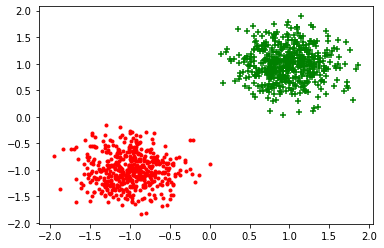

In [ ]:
np.random.seed(0)
X, Y = gen_arti()
plot_data(X,Y)

Acc: 0.0


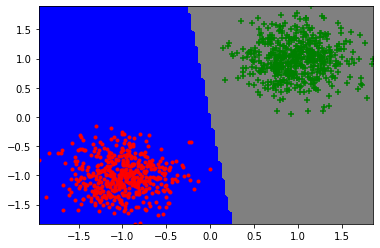

In [ ]:
np.random.seed(2)
M = Linear(X.shape[1], 1)
#print(M._parameters)
y_pred = M.forward(X)
y_hat = np.sign(y_pred)
plot_frontiere(X,lambda x : np.sign(M.forward(x)),step=100)
plot_data(X,Y)
res = np.where(y_hat == Y, 1, 0).sum()
print("Acc:",res/len(Y))

Acc: 1.0


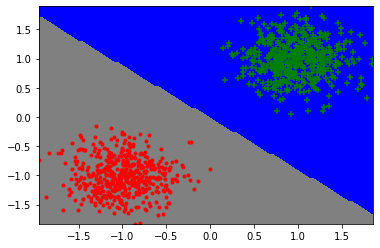

In [ ]:
loss = MSELoss()
L = loss.forward(Y,y_hat)
delta = loss.backward(Y,y_pred)
M.backward_update_gradient(X,delta)
M.update_parameters()
#print(M._parameters)
y_pred = M.forward(X)
y_hat = np.sign(y_pred)
plot_frontiere(X,lambda x : np.sign(M.forward(x)),step=100)
plot_data(X,Y)
res = np.where(y_hat == Y, 1, 0).sum()
print("Acc:",res/len(Y))

## Deux couches

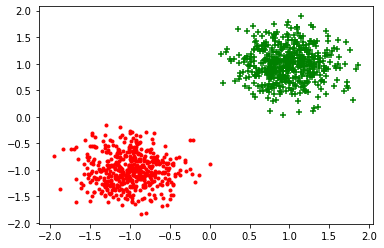

In [ ]:
np.random.seed(0)
X, Y = gen_arti()
plot_data(X,Y)

Acc: 0.538


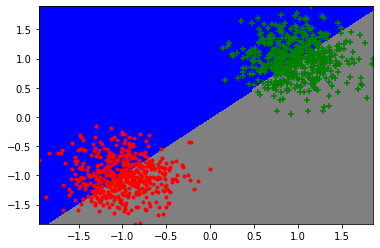

In [ ]:
np.random.seed(3)
# Couche 1: 2 neurones, couche 2: 1 neurone
M1 = Linear(X.shape[1], 2)
M2 = Linear(M1._parameters.shape[0], 1)
#print(M1._parameters, M2._parameters)
z_1 = M1.forward(X)
z_2 = M2.forward(z_1)
y_hat = np.sign(z_2)


#print(z_1.shape)
#print(z_2.shape)
#print(M2._parameters)
#print(M2._parameters.shape)
plot_frontiere(X,lambda x : np.sign(M2.forward(M1.forward(x))),step=100)
plot_data(X,Y)
res = np.where(y_hat == Y, 1, 0).sum()
print("Acc:",res/len(Y))

Acc: 0.943


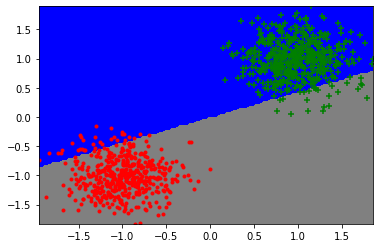

In [ ]:
#Back propagation
loss = MSELoss()
delta2 = loss.backward(Y,z_2)
#M2
M2.backward_update_gradient(X,delta2)
delta1= M2.backward_delta(z_1, delta2)
M2.update_parameters(gradient_step=1e-4) # eps 1e-3 trop grand -> sortir de min local

#M1
M1.backward_update_gradient(X,delta1)
M1.update_parameters(gradient_step=1e-4)

#Foward
z_1 = M1.forward(X)
z_2 = M2.forward(z_1)
y_hat = np.sign(z_2)
plot_frontiere(X,lambda x : np.sign(M2.forward(M1.forward(x))),step=100)
plot_data(X,Y)
res = np.where(y_hat == Y, 1, 0).sum()
print("Acc:",res/len(Y))

# Non-linéaire

Lin-Tanh-Lin-Sig

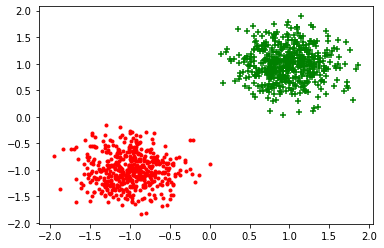

In [ ]:
np.random.seed(0)
X, Y = gen_arti()
Y = np.where(Y==-1,0,1)
plot_data(X,Y)

Acc: 0.035


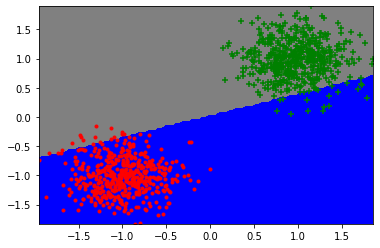

In [ ]:
np.random.seed(6)
#ini
MLin1 = Linear(X.shape[1],2)
MtanH = TanH()
MLin2 = Linear(MLin1._parameters.shape[0], 1) #w_h1(out,in)
MSig = Sigmoide()
#forward
z_1 = MLin1.forward(X)
z_1_tan = MtanH.forward(z_1)
z_2 = MLin2.forward(z_1_tan)
z_2_sig = MSig.forward(z_2)
#decision
y_pred = np.where(z_2_sig>0.5,1,0)

def f_sig(X):
  A = MSig.forward(MLin2.forward(MtanH.forward(MLin1.forward(X))))
  return np.where(A>0.5,1,0)

#plot
plot_frontiere(X,f_sig,step=100)
plot_data(X,Y)
res = np.where(y_pred == Y, 1, 0).sum()
print("Acc:",res/len(Y))

Iter 1, Accuracy: 0.061
Iter 2, Accuracy: 0.095
Iter 3, Accuracy: 0.16
Iter 4, Accuracy: 0.27
Iter 5, Accuracy: 0.426
Iter 6, Accuracy: 0.6
Iter 7, Accuracy: 0.734
Iter 8, Accuracy: 0.822
Iter 9, Accuracy: 0.875
Iter 10, Accuracy: 0.911


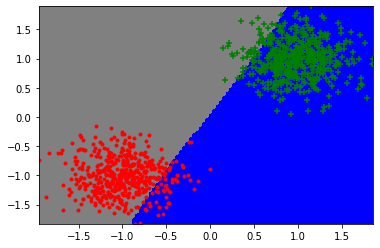

In [ ]:
nbiter = 10
for i in range(nbiter):
  #Back propagation
  loss = MSELoss()
  delta_sortie = loss.backward(Y,z_2_sig)
  #Sig
  delta_sig = MSig.backward_delta(z_2,delta_sortie)
  #Lineaire 2
  MLin2.backward_update_gradient(z_1_tan,delta_sig)
  delta_2 = MLin2.backward_delta(z_1_tan, delta_sig)
  MLin2.update_parameters(gradient_step=1e-4)
  #TanH
  delta_tanH = MtanH.backward_delta(z_1,delta_2)
  #Lineaire 2
  MLin1.backward_update_gradient(X,delta_tanH)
  MLin1.update_parameters(gradient_step=1e-4)


  #forward
  z_1 = MLin1.forward(X)
  z_1_tan = MtanH.forward(z_1)
  z_2 = MLin2.forward(z_1_tan)
  z_2_sig = MSig.forward(z_2)
  #decision
  y_pred = np.where(z_2_sig>0.5,1,0)


  #plot
  plot_frontiere(X,f_sig,step=100)
  plot_data(X,Y)
  res = np.where(y_pred == Y, 1, 0).sum()
  print(f"Iter {i+1}, Accuracy:",res/len(Y))

# Encapsulage

## Sequentiel

In [ ]:
def f_sig_seq(seq, X):
  A = seq.forward(X)
  return np.where(A>0.5,1,-1)


class Sequentiel():
  def __init__(self, *module):
    self.net = module

  def forward(self, input):
    z = input
    self.input = [input]
    for m in self.net:
      z = m.forward(z)
      self.input.append(z)
    return z
  
  def backward(self,loss, Y,gradient_step=0.001):
    delta_ = loss.backward(Y,self.input[-1])
    #print(len(self.input), len(self.net))
    for i in range(len(self.net)-1,-1,-1): # BACKKKKWARDDDDDDDD
      #print(type(self.net[i]).__name__)
      if type(self.net[i]).__name__ != 'Linear': # si fonction d'activation
        #print(f"SEQ ACTI {type(self.net[i]).__name__} input {self.input[i].shape} delta {delta_.shape}")
        delta_ = self.net[i].backward_delta(self.input[i], delta_)
      else: #Lineaire
        #print("LIN")
        #print(f"SEQ LIN {type(self.net[i]).__name__} input {self.input[i].shape} delta {delta_.shape}")
        self.net[i].backward_update_gradient(self.input[i],delta_)
        delta_ = self.net[i].backward_delta(self.input[i], delta_)
        self.net[i].update_parameters(gradient_step=gradient_step)


### Test Sequentiel

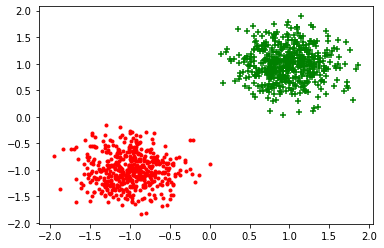

In [ ]:
np.random.seed(0)
X, Y = gen_arti()
Y = np.where(Y==-1,0,1)
plot_data(X,Y)

Acc: 0.035


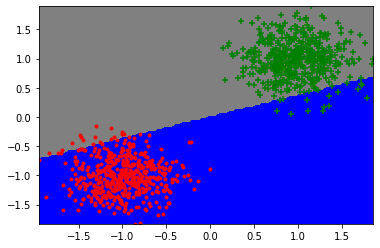

In [ ]:
np.random.seed(6) # pour assurer c'est identique pour les tests
#ini
MLin1 = Linear(X.shape[1],2)
MtanH = TanH()
MLin2 = Linear(MLin1._parameters.shape[0], 1) #w_h1(out,in)
MSig = Sigmoide()
#ini seq
net = Sequentiel(MLin1, MtanH, MLin2, MSig)
#forward
z = net.forward(X)
#decision
y_pred = np.where(z>0.5,1,0)

net_copy = cp.deepcopy(net) # afin de ne pas modifier notre network

#plot
plot_frontiere(X,lambda x : f_sig_seq(net_copy, x),step=100)
plot_data(X,Y)
res = np.where(y_pred == Y, 1, 0).sum()
print("Acc:",res/len(Y))

Iter 1, Accuracy: 0.061
Iter 2, Accuracy: 0.095
Iter 3, Accuracy: 0.16
Iter 4, Accuracy: 0.27
Iter 5, Accuracy: 0.426
Iter 6, Accuracy: 0.6
Iter 7, Accuracy: 0.734
Iter 8, Accuracy: 0.822
Iter 9, Accuracy: 0.875
Iter 10, Accuracy: 0.911


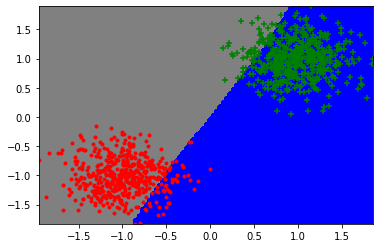

In [ ]:
nbiter = 10
for i in range(nbiter):
  #Back propagation
  net.backward(MSELoss(), Y,gradient_step=1e-4)


  #forward
  z = net.forward(X)
  #decision
  y_pred = np.where(z>0.5,1,0)

  net_copy = cp.deepcopy(net)

  #plot
  plot_frontiere(X,lambda x : f_sig_seq(net_copy, x),step=100)
  plot_data(X,Y)
  res = np.where(y_pred == Y, 1, 0).sum()
  print(f"Iter {i+1}, Accuracy:",res/len(Y))

## Optim

In [ ]:
class Optim():
  def __init__(self, net, loss, eps):
    self.net = net
    self.loss = loss
    self.eps = eps

  def step(self, batch_x, batch_y):
    y_hat = self.net.forward(batch_x)
    loss = self.loss.forward(batch_y, y_hat)
    self.net.backward(self.loss, batch_y,gradient_step=self.eps)
    return y_hat, loss

### Test Optim

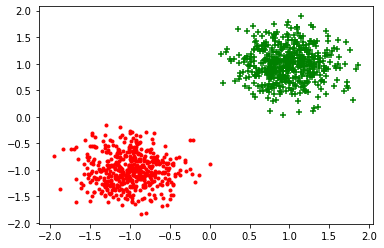

In [ ]:
np.random.seed(0)
X, Y = gen_arti()
Y = np.where(Y==-1,0,1)
plot_data(X,Y)

In [ ]:
np.random.seed(6)
#ini
MLin1 = Linear(X.shape[1],2)
MtanH = TanH()
MLin2 = Linear(MLin1._parameters.shape[0], 1) #w_h1(out,in)
MSig = Sigmoide()
#ini seq
net = Sequentiel(MLin1, MtanH, MLin2, MSig)
# Optim
eps = 1e-4
Opt = Optim(net, MSELoss(), eps)
y_hat, _ = Opt.step(X,Y)

#decision
y_pred = np.where(y_hat>0.5,1,0)

res = np.where(y_pred == Y, 1, 0).sum()
print("Acc:",res/len(Y))

Acc: 0.035


Iter 1, Accuracy: 0.061
Iter 2, Accuracy: 0.095
Iter 3, Accuracy: 0.16
Iter 4, Accuracy: 0.27
Iter 5, Accuracy: 0.426
Iter 6, Accuracy: 0.6
Iter 7, Accuracy: 0.734
Iter 8, Accuracy: 0.822
Iter 9, Accuracy: 0.875
Iter 10, Accuracy: 0.911


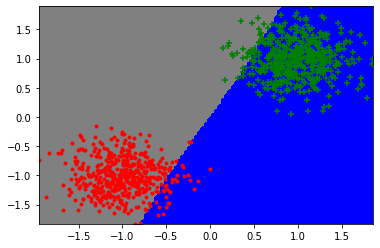

In [ ]:
Opt = Optim(net, MSELoss(), eps)
nbiter = 10
for i in range(nbiter):
  y_hat, _ = Opt.step(X,Y)

  #decision
  y_pred = np.where(y_hat>0.5,1,0)

  net_copy = cp.deepcopy(net)

  #plot
  plot_frontiere(X,lambda x : f_sig_seq(net_copy, x),step=100)
  plot_data(X,Y)
  res = np.where(y_pred == Y, 1, 0).sum()
  print(f"Iter {i+1}, Accuracy:",res/len(Y))

La frontière est différente car il s'agit de la frontière de l'epoch prochain comme step met à jours les parametres du réseau

## SGD

In [ ]:
def SGD(net, data, loss, eps=1e-4, batch_taille=40, nb_iter=5):
  """Apprentissage du réseaux en utilisant mini-batch et descente de gradient
  Arg:
  net: le réseau de neurones
  data: le jeu de données X, Y
  loss: fonction cout
  eps: pas de gradient
  batch_taille: la taille de chaque batch
  nb_inter: nombre d'itérations
  """
  opt = Optim(net, loss, eps)
  n = len(data)
  data_train = cp.deepcopy(data)
  for i in range(nb_iter): # pour chaque epochs
    np.random.shuffle(data_train)
    tab_mini_batches = [data_train[k:k+batch_taille] for k in range(0, n, batch_taille)] #decouper en mini batches
    for mini_batch in tab_mini_batches: # apprentissage sur chaque mini batch
      batch_x, batch_y = np.array(mini_batch[:,0].tolist()), np.array(mini_batch[:,1].tolist()) # array de array -> array de liste
      opt.step(batch_x, batch_y)

### Test SGD

<ipython-input-99-f6df407cdf9f>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array([np.array([x,y]).tolist() for x, y in zip(X,Y)]) #merge x et y en un jeu de données


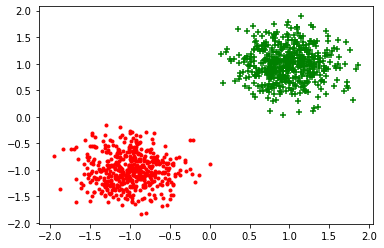

In [ ]:
np.random.seed(0)
X, Y = gen_arti()
Y = np.where(Y==-1,0,1)
data = np.array([np.array([x,y]).tolist() for x, y in zip(X,Y)]) #merge x et y en un jeu de données
plot_data(X,Y)

In [ ]:
np.random.seed(6)
#ini
MLin1 = Linear(X.shape[1],2)
MtanH = TanH()
MLin2 = Linear(MLin1._parameters.shape[0], 1) #w_h1(out,in)
MSig = Sigmoide()
#ini seq
net = Sequentiel(MLin1, MtanH, MLin2, MSig)

Acc: 0.903


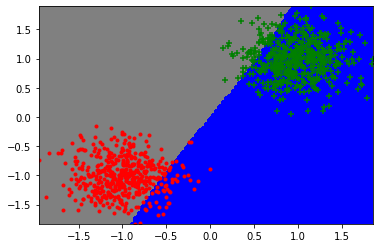

In [ ]:
SGD(net, data, MSELoss(), eps=1e-4, batch_taille=40, nb_iter=10)

y_hat = net.forward(X)
#decision
y_pred = np.where(y_hat>0.5,1,0)

net_copy = cp.deepcopy(net) # afin de ne pas modifier notre network

#plot
plot_frontiere(X,lambda x : f_sig_seq(net_copy, x),step=100)
plot_data(X,Y)
res = np.where(y_pred == Y, 1, 0).sum()
print("Acc:",res/len(Y))

# Multi-classe

# Softmax et Cout entropique

## Data manuscrits

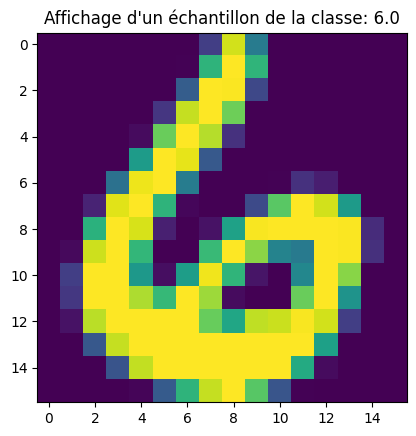

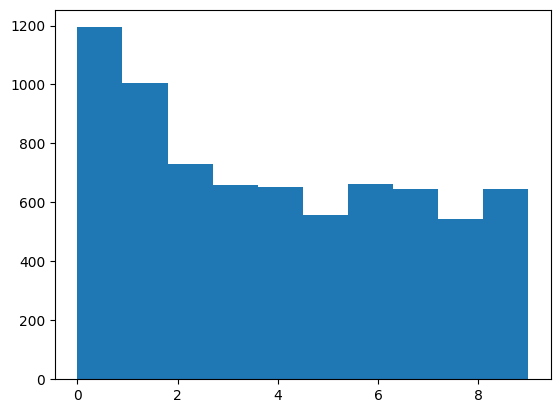

In [ ]:
def load(filename):
    f=open(filename,'r')
    s = f.readline() # virer la premiere ligne
    X = np.array([[float(d) for d in lig.split()] for lig in f if len(lig)>10])
    Y = X[:,0] # premiere colonne
    X = X[:,1:]
    f.close()
    return X,Y

X,Y = load('data/usps_train.txt')
Xt,Yt = load('data/usps_test.txt')

# affichage d'un échantillon
plt.figure()
index = 0
plt.imshow(X[index].reshape(16,16), interpolation=None)
plt.title('Affichage d\'un échantillon de la classe: '+str(Y[index]))

# étude très rapide des données:
plt.figure()
plt.hist(Y, 10) # histogramme de répartition des 10 classes
plt.show()

In [ ]:
Y = Y.astype(int)
Y_onehot = np.zeros((Y.size,10));
Y_onehot[np.arange(Y.size),Y]=1
Y_onehot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [ ]:
np.random.seed(6)
#ini
MLin1 = Linear(X.shape[1],150)
MtanH = TanH()
MLin2 = Linear(MLin1._parameters.shape[0], 10) # 10 classes
MSig = Sigmoide()
#ini seq
net = Sequentiel(MLin1, MtanH, MLin2, MSig)

#forward
z = net.forward(X)

l = SMCELoss()
l.forward(Y_onehot, z)

# prediction = argmax
y_pred = np.argmax(logsoftmax(z), axis = 1)
# accu
res = np.where(y_pred == Y, 1, 0).sum()
print("Acc:",res/len(Y))

Acc: 0.06761761075298313


In [ ]:
nbiter = 100
eps = 0.005
for i in range(nbiter):
  #Back propagation
  net.backward(SMCELoss(), Y_onehot,gradient_step=eps)

  #forward
  z = net.forward(X)

  # prediction = argmax
  y_pred = np.argmax(logsoftmax(z), axis = 1)
  # accu
  res = np.where(y_pred == Y, 1, 0).sum()
  print(f"Iter {i+1}, Accuracy:",res/len(Y))

Iter 1, Accuracy: 0.2216431216568372
Iter 2, Accuracy: 0.39459607735564395
Iter 3, Accuracy: 0.5133726512138252
Iter 4, Accuracy: 0.6045809902619668
Iter 5, Accuracy: 0.6571115073378138
Iter 6, Accuracy: 0.6933205321629407
Iter 7, Accuracy: 0.7110135783843095
Iter 8, Accuracy: 0.7248662734878617
Iter 9, Accuracy: 0.7259635166643807
Iter 10, Accuracy: 0.7499657111507337
Iter 11, Accuracy: 0.7779454121519682
Iter 12, Accuracy: 0.7889178439171581
Iter 13, Accuracy: 0.8005760526676725
Iter 14, Accuracy: 0.8066108901385269
Iter 15, Accuracy: 0.8111370182416678
Iter 16, Accuracy: 0.821835139212728
Iter 17, Accuracy: 0.8151145247565492
Iter 18, Accuracy: 0.8336305033603072
Iter 19, Accuracy: 0.8439171581401728
Iter 20, Accuracy: 0.8432313811548484
Iter 21, Accuracy: 0.853518035934714
Iter 22, Accuracy: 0.8515978603758058
Iter 23, Accuracy: 0.8610615827732822
Iter 24, Accuracy: 0.8544781237141682
Iter 25, Accuracy: 0.8643533123028391
Iter 26, Accuracy: 0.8563982992730764
Iter 27, Accuracy: 0.8

Test SGD

In [ ]:
X,Y = load('data/usps_train.txt')
Xt,Yt = load('data/usps_test.txt')
Y = Y.astype(int)
Y_onehot = np.zeros((Y.size,10));
Y_onehot[np.arange(Y.size),Y]=1

data = np.array([np.array([x,y]).tolist() for x, y in zip(X,Y_onehot)])

<ipython-input-107-cdb086115867>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array([np.array([x,y]).tolist() for x, y in zip(X,Y_onehot)])


In [ ]:
np.random.seed(6)
#ini le reseau
MLin1 = Linear(X.shape[1],256)
MLin2 = Linear(MLin1._parameters.shape[0], 128)
MLin3 = Linear(MLin2._parameters.shape[0], 10) # 10 classes
MSig = Sigmoide()
#ini seq
net = Sequentiel(MLin1, MSig, MLin2, MSig,MLin3,MSig)

In [ ]:
# SGD
SGD(net, data, SMCELoss(), eps=1e-2, batch_taille=300, nb_iter=100)

z = net.forward(X)

# prediction = argmax
y_pred = np.argmax(logsoftmax(z), axis = 1)
# accu
res = np.where(y_pred == Y, 1, 0).sum()
print("Acc:",res/len(Y))

Acc: 0.8996022493485119


# Auto-encodeur

Text(0.5, 1.0, "Affichage d'un échantillon de la classe: 6.0")

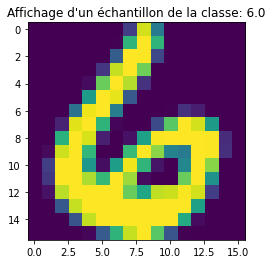

In [ ]:
X,Y = load('data/usps_train.txt')

# affichage d'un échantillon
plt.figure()
index = 0
plt.imshow(X[index].reshape(16,16), interpolation=None)
plt.title('Affichage d\'un échantillon de la classe: '+str(Y[index]))

## Tester sur 1 image

In [ ]:
img = X[0].reshape(-1,256)

Text(0.5, 1.0, "Affichage d'un échantillon de la classe: 6.0")

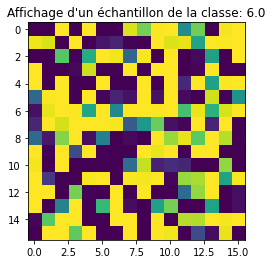

In [ ]:
np.random.seed(6) # pour assurer c'est identique pour les tests
#Encodage
MLin1_encodage = Linear(256,100)
MLin2_encodage = Linear(MLin1_encodage._parameters.shape[0], 10)

#Decodage
MLin1_decodage = Linear(10,100)
MLin2_decodage = Linear(MLin1_decodage._parameters.shape[0], 256)
#Seq encodage-decodage
MtanH = TanH()
MSig = Sigmoide()
net = Sequentiel(MLin1_encodage, MtanH, MLin2_encodage, MtanH, MLin1_decodage, MtanH, MLin2_decodage, MSig)

z = net.forward(img)

# affichage d'un échantillon
plt.figure()
index = 0
plt.imshow(z[index].reshape(16,16), interpolation=None)
plt.title('Affichage d\'un échantillon de la classe: '+str(Y[index]))

Text(0.5, 1.0, "Affichage d'un échantillon de la classe: 6.0")

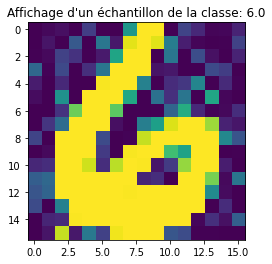

In [ ]:
nbiter = 2000
for i in range(nbiter):
  #Back propagation
  net.backward(BCELoss(), img,gradient_step=1e-4)
  #forward
  z = net.forward(img)

# affichage d'un échantillon
plt.figure()
index = 0
plt.imshow(z[index].reshape(16,16), interpolation=None)
plt.title('Affichage d\'un échantillon de la classe: '+str(Y[index]))

Text(0.5, 1.0, "Affichage d'un échantillon de la classe: 3.0")

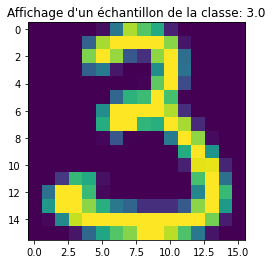

In [ ]:
# affichage d'un échantillon
plt.figure()
index = 4
plt.imshow(X[index].reshape(16,16), interpolation=None)
plt.title('Affichage d\'un échantillon de la classe: '+str(Y[index]))

Text(0.5, 1.0, "Affichage d'un échantillon de la classe: 3.0")

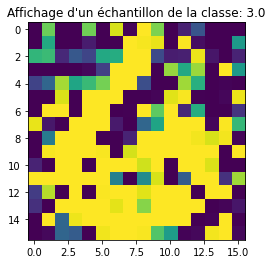

In [ ]:
index_img = 4
z = net.forward(X[index_img].reshape(-1,256))

# affichage d'un échantillon
plt.figure()
plt.imshow(z[0].reshape(16,16), interpolation=None)
plt.title('Affichage d\'un échantillon de la classe: '+str(Y[index]))

Si l'on entraîne sur une seule image, le réseau apprend  à décompresser cette seule image.

## Expériementations sur l'architecture

In [ ]:
def creerEncoder(dimensions, fActivation):
  """Creer un encoder
  dimensions: liste des tailles des couches
  fActivation: la fonction d'activation pour chaque couche
  """
  l_module = []
  for i in range(len(dimensions)-1):
    l_module.append(Linear(dimensions[i],dimensions[i+1]))
    l_module.append(fActivation)
  return l_module

def creerDecoder(dimensions, fActivation, fSortie = Sigmoide()):
  """Creer un decoder
  dimensions: liste des tailles des couches
  fActivation: la fonction d'activation pour chaque couche
  """
  l_module = []
  for i in range(len(dimensions)-1):
    l_module.append(Linear(dimensions[i],dimensions[i+1]))
    l_module.append(fActivation)
  l_module[-1] = fSortie #changer la fonction d'activation de la derniere couche par fSortie
  return l_module

### Structure simple avec tangente hyperbolique

In [ ]:
import base64
from IPython.display import Image, display

def mm(graph):
  graphbytes = graph.encode("ascii")
  base64_bytes = base64.b64encode(graphbytes)
  base64_string = base64_bytes.decode("ascii")
  display(Image(url="https://mermaid.ink/img/" + base64_string))

In [ ]:
# Encodage
mm("""
graph LR;
    N1(Lin.256,128)--> N2(TanH);
    N2--> N3(Lin.128,64);
    N3--> N4(TanH);
    N4--> N5(Lin.64,18);
    N5--> N6(TanH);
""")

In [ ]:
# Décodage
mm("""
graph LR;
    N5(Lin.18,64)--> N6(TanH);
    N6--> N7(Lin.64,128);
    N7--> N8(TanH);
    N8--> N9(Lin.128,256);
    N9--> N10(Sigmoide);
""")

In [ ]:
X,Y = load('data/usps_train.txt')
data = np.array([np.array([x,y]).tolist() for x, y in zip(X,X)])

Text(0.5, 1.0, "Affichage d'un échantillon de la classe: 7.0")

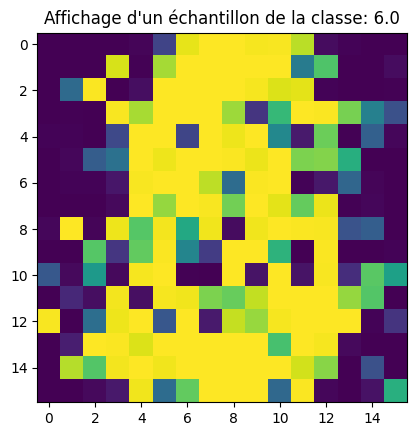

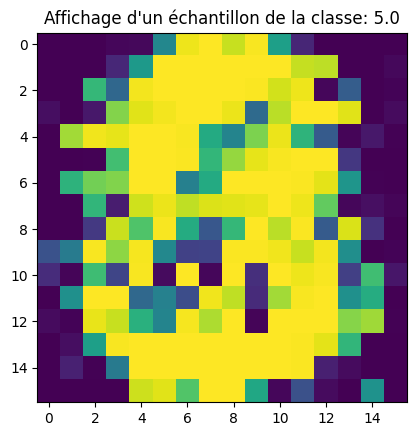

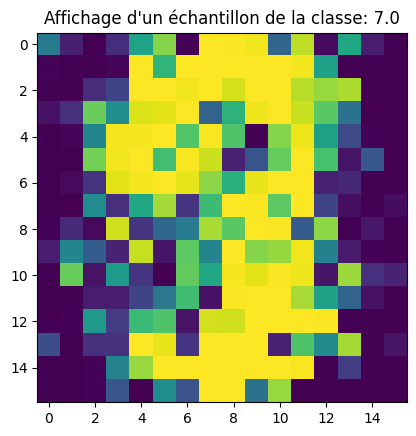

In [ ]:
np.random.seed(0)
dim = [256,128,64,18]
l_encoder = creerEncoder(dim, TanH())
l_decoder = creerDecoder(dim[::-1], TanH(), fSortie = Sigmoide())

net = Sequentiel(*l_encoder, *l_decoder)

# tangente hyperbolique
# eps 3e-6, mini-b 32, epochs 20: ressembler un peu
# eps 4e-6,mini-b 32, epochs 20: un peu moins
SGD(net, data, BCELoss(), eps=3e-6, batch_taille=32, nb_iter=20)

z = net.forward(X)

# affichage d'un échantillon
plt.figure()
index = 0
plt.imshow(z[index].reshape(16,16), interpolation=None)
plt.title('Affichage d\'un échantillon de la classe: '+str(Y[index]))
# affichage d'un échantillon
plt.figure()
index = 1
plt.imshow(z[index].reshape(16,16), interpolation=None)
plt.title('Affichage d\'un échantillon de la classe: '+str(Y[index]))
# affichage d'un échantillon
plt.figure()
index = 22
plt.imshow(z[index].reshape(16,16), interpolation=None)
plt.title('Affichage d\'un échantillon de la classe: '+str(Y[index]))

Le résultat retourné se ressemble un peu des chiffres originaux.

#### Apprendre sur le clustering induit par l'espace latent

In [ ]:
from sklearn.cluster import KMeans

MEncoder = Sequentiel(*l_encoder)

X_latent = MEncoder.forward(X)
kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(X_latent)

In [ ]:
# Évaluation des performances
cluster_labels = kmeans.labels_

# Calculer purity
for i in np.unique(Y):
  inx_cluster = np.where(cluster_labels==i)[0]
  Y_cluster = Y[inx_cluster]
  val, occ = np.unique(Y_cluster, return_counts=True)
  print(f"Purity cluster {i}, valeur majoritaire {val[np.argmax(occ)]}: {np.max(occ)/np.sum(occ)}")

Purity cluster 0.0, valeur majoritaire 0.0: 0.5599201065246339
Purity cluster 1.0, valeur majoritaire 1.0: 0.9568627450980393
Purity cluster 2.0, valeur majoritaire 7.0: 0.2993762993762994
Purity cluster 3.0, valeur majoritaire 6.0: 0.15657245401525346
Purity cluster 4.0, valeur majoritaire 9.0: 0.3435804701627486
Purity cluster 5.0, valeur majoritaire 2.0: 0.30727762803234504
Purity cluster 6.0, valeur majoritaire 9.0: 0.28717948717948716
Purity cluster 7.0, valeur majoritaire 6.0: 0.3620689655172414
Purity cluster 8.0, valeur majoritaire 2.0: 0.2540322580645161
Purity cluster 9.0, valeur majoritaire 2.0: 0.5368421052631579


Il nous semble que les 2 clusters dont purité sont pas trop mauvaise sont le cluster où 1 est la majorité (purtié 0.95), l'autre est le cluster où 0 est la majorité (purité 0.55). En plus, il y a un cluster où 2 prends la majorité (purité 0.53) mais la valeur 2 se dispersent vers autre clusters (clusters numéro 5, 8 et 9 ont 2 comme majorité).

#### Projection 2D avec T-SNE

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

MEncoder = Sequentiel(*l_encoder)

X_latent = MEncoder.forward(X)

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(X_latent)
df = pd.DataFrame()
df["y"] = Y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7291 samples in 0.001s...
[t-SNE] Computed neighbors for 7291 samples in 0.626s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7291
[t-SNE] Computed conditional probabilities for sample 2000 / 7291
[t-SNE] Computed conditional probabilities for sample 3000 / 7291
[t-SNE] Computed conditional probabilities for sample 4000 / 7291
[t-SNE] Computed conditional probabilities for sample 5000 / 7291
[t-SNE] Computed conditional probabilities for sample 6000 / 7291
[t-SNE] Computed conditional probabilities for sample 7000 / 7291
[t-SNE] Computed conditional probabilities for sample 7291 / 7291
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.673264
[t-SNE] KL divergence after 1000 iterations: 0.557642


[Text(0.5, 1.0, 'T-SNE projection sur data manuscrits')]

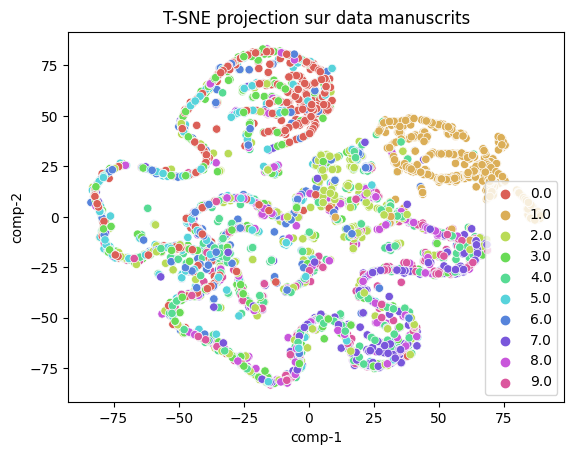

In [ ]:
#plot
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="T-SNE projection sur data manuscrits")

* 1 est bien séparé des autres chiffres
* une grande partie de 0 et de 2 se collent bien.
* Pour les autres ce n'est pas faicle pour distinguer comme elles se mélangent.</br>
Cette image renforce notre remarque sur K-Means, où le cluster dont majorité est 1 et le cluster dont majorité est 0 ont la valeur de purité la plus haute (0.95 et 0.55 respectivement). Quant à 2, nous voyons que il y a bien une partie où les 2 se collent, mais les autres valeurs 2 se disperse partout.

### Structure complexe avec ReLU

In [ ]:
# Encodage
mm("""
graph LR;
    N1(Lin.256,128)--> N2(ReLU);
    N2--> N3(Lin.128,64);
    N3--> N4(ReLU);
    N4--> N5(Lin.64,36);
    N5--> N6(ReLU);
    N6--> N7(Lin.36,18);
    N7--> N8(ReLU);
    N8--> N9(Lin.18,9);
    N9--> N10(ReLU);
""")

In [ ]:
# Décodage
mm("""
graph LR;
    N1(Lin.9,18)--> N2(ReLU);
    N2--> N3(Lin.18,36);
    N3--> N4(ReLU);
    N4--> N5(Lin.36,64);
    N5--> N6(ReLU);
    N6--> N7(Lin.64,128);
    N7--> N8(ReLU);
    N8--> N9(Lin.128,256);
    N9--> N10(Sigmoide);
""")

In [ ]:
X,Y = load('data/usps_train.txt')
data = np.array([np.array([x,y]).tolist() for x, y in zip(X,X)])

Text(0.5, 1.0, "Affichage d'un échantillon de la classe: 6.0")

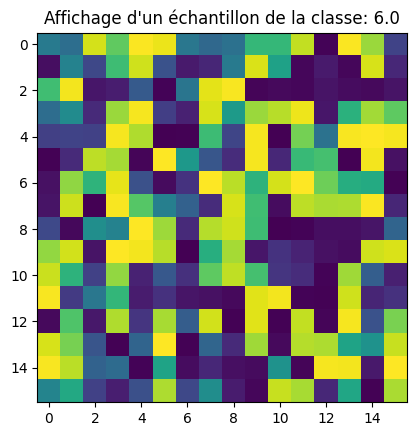

In [ ]:
dim = [256,128,64,36,18,9]
l_encoder = creerEncoder(dim, ReLU_factor(factor= 0.2))
l_decoder = creerDecoder(dim[::-1], ReLU_factor(factor= 0.2), fSortie = Sigmoide())

net = Sequentiel(*l_encoder, *l_decoder)

z = net.forward(X)

# affichage d'un échantillon
plt.figure()
index = 0
plt.imshow(z[index].reshape(16,16), interpolation=None)
plt.title('Affichage d\'un échantillon de la classe: '+str(Y[index]))

Text(0.5, 1.0, "Affichage d'un échantillon de la classe: 7.0")

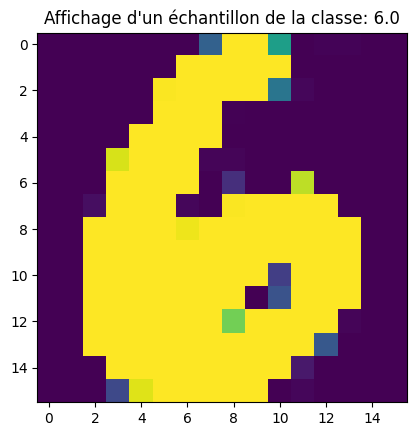

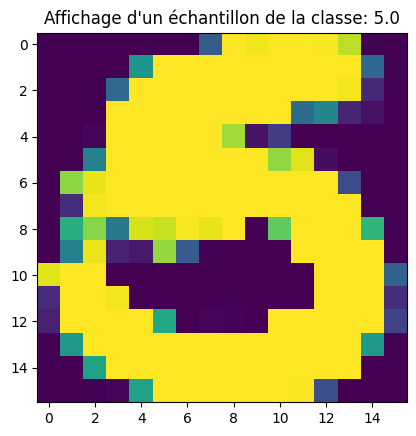

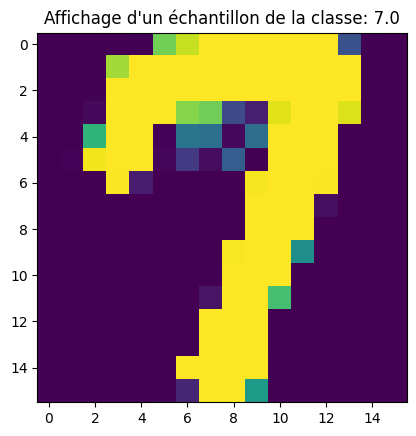

In [ ]:
SGD(net, data, BCELoss(), eps=1e-4, batch_taille=32, nb_iter=100)

z = net.forward(X)

# affichage d'un échantillon
plt.figure()
index = 0
plt.imshow(z[index].reshape(16,16), interpolation=None)
plt.title('Affichage d\'un échantillon de la classe: '+str(Y[index]))
# affichage d'un échantillon
plt.figure()
index = 1
plt.imshow(z[index].reshape(16,16), interpolation=None)
plt.title('Affichage d\'un échantillon de la classe: '+str(Y[index]))
# affichage d'un échantillon
plt.figure()
index = 22
plt.imshow(z[index].reshape(16,16), interpolation=None)
plt.title('Affichage d\'un échantillon de la classe: '+str(Y[index]))

Le résultat donné par cette architecture nous semble bien. Nous avons reconstruit les manuscrits après d'avoir les encodé, malgré que le temps d'exécution augmente beaucoup (100 itérations).

#### Apprendre sur le clustering induit par l'espace latent

In [ ]:
from sklearn.cluster import KMeans

MEncoder = Sequentiel(*l_encoder)

X_latent = MEncoder.forward(X)

kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(X_latent) # manuscrit de 0 a 9 -> 10 classes

In [ ]:
# Évaluation des performances
cluster_labels = kmeans.labels_

# Calculer purity
for i in np.unique(Y):
  inx_cluster = np.where(cluster_labels==i)[0]
  Y_cluster = Y[inx_cluster]
  val, occ = np.unique(Y_cluster, return_counts=True)
  print(f"Purity cluster {i}, valeur majoritaire {val[np.argmax(occ)]}: {np.max(occ)/np.sum(occ)}")

Purity cluster 0.0, valeur majoritaire 2.0: 0.25074850299401197
Purity cluster 1.0, valeur majoritaire 9.0: 0.4256926952141058
Purity cluster 2.0, valeur majoritaire 7.0: 0.35123523093447906
Purity cluster 3.0, valeur majoritaire 0.0: 0.9699863574351978
Purity cluster 4.0, valeur majoritaire 1.0: 0.9769319492502884
Purity cluster 5.0, valeur majoritaire 6.0: 0.8009554140127388
Purity cluster 6.0, valeur majoritaire 8.0: 0.7910798122065728
Purity cluster 7.0, valeur majoritaire 7.0: 0.4222737819025522
Purity cluster 8.0, valeur majoritaire 3.0: 0.4377797672336616
Purity cluster 9.0, valeur majoritaire 2.0: 0.8729411764705882


Nous remarquons que les clusters ont bien leur valeur de purité assez haute, 5 parmi 10 clusters ont la purtié supérieur que 80%.

#### Projection 2D avec T-SNE

Nous allons projeter les données encodées par l'encoder sur un plan 2D, afin de consulter si les données encodées gardent encore les caractèristiques des manuscrits des chiffres qu'ils présentent même si la dimension est diminuée significamment.

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(X_latent)
df = pd.DataFrame()
df["y"] = Y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7291 samples in 0.012s...
[t-SNE] Computed neighbors for 7291 samples in 0.635s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7291
[t-SNE] Computed conditional probabilities for sample 2000 / 7291
[t-SNE] Computed conditional probabilities for sample 3000 / 7291
[t-SNE] Computed conditional probabilities for sample 4000 / 7291
[t-SNE] Computed conditional probabilities for sample 5000 / 7291
[t-SNE] Computed conditional probabilities for sample 6000 / 7291
[t-SNE] Computed conditional probabilities for sample 7000 / 7291
[t-SNE] Computed conditional probabilities for sample 7291 / 7291
[t-SNE] Mean sigma: 0.954458
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.386879
[t-SNE] KL divergence after 1000 iterations: 1.087872


[Text(0.5, 1.0, 'T-SNE projection sur data manuscrits')]

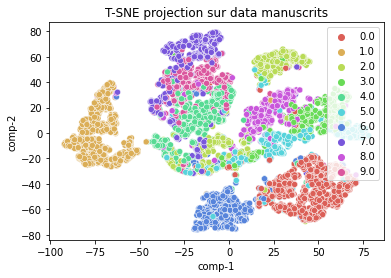

In [ ]:
#plot
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 10),
                data=df).set(title="T-SNE projection sur data manuscrits")

**Rermarque**</br>
Nous remarquons sur la projection sur la présentation produite par l'espace lantent:


*   1 est bien séparée d'autres chiffires
*   6 et 9 sont séparées des autres aussi mais il y des une partie des 2 se ressemblent.
*   En haut, nous voyons que 4 et 9 se ressemblent
*   Tout en haut au milieu, nous voyons que 7 et 9 se ressemblent
*   Au milieu, il y a une partie des chiffres 2, 7, 5 et 4 se ressemblent.

Après d'avoir être encodées vers une dimension plus petite, de 256 à 9. Certaines chiffres encore gardent leurs caractèristiques comme 4 et 9 peuvent se ressembler, aussi 7 et 9 ou bien 0 et 6.
Pour les données encodéess dont la majorité se mélange, lors du décodage, la présentation reconstruite peut être se ressemblent.

## Débruitage

à faire

## Pré-traiter les données avec l'auto-encodeur

à faire

# Convolutional neural network - CNN

## Convolution 1D

In [ ]:
class Conv1D(Module):
  def __init__(self, k_size, chan_in, chan_out, stride=1):
    self.k_size = k_size
    self.chan_in = chan_in
    self.chan_out = chan_out
    self.stride = stride
    self._parameters = np.random.randn(chan_out, k_size*chan_in) # nb couche X ksize*C
    if chan_out == 1:
      self._parameters.reshape(1, -1)
    self._gradient = np.zeros_like(self._parameters)

  def zero_grad(self):
    self._gradient = np.zeros_like(self._parameters)

  def forward(self, X):
    n_batch, d, C = X.shape
    o = np.zeros((n_batch, (d - self.k_size)//self.stride + 1, self.chan_out)) # une sortie est 2D d_out X chan_out
    for i in range(0,(d-self.k_size)//self.stride+1,self.stride):
        # applatir la fenetre X
        fenetre_X = X[:, i*self.stride:i*self.stride+self.k_size, :].reshape(n_batch, -1)
        o[:, i, :] = np.dot(fenetre_X, self._parameters.T)
    return o

  def update_parameters(self, gradient_step=1e-3):

        self._parameters -= gradient_step*self._gradient
        self.zero_grad()
        
  def backward_update_gradient(self, input, delta):
      n_batch, d, C = input.shape
      grad = np.zeros_like(self._parameters)
      for i in range(0, (d - self.k_size) // self.stride + 1, self.stride):
          # applatir la fenetre X
          fenetre_X = input[:, i * self.stride:i * self.stride + self.k_size, :].reshape(n_batch, -1)
          grad += np.dot(delta[:, i, :].T, fenetre_X)
      self._gradient += grad
        

  def backward_delta(self, input, delta):
      n_batch, d, C = input.shape
      delta_h = np.zeros_like(input)
      for i in range(0,(d-self.k_size)//self.stride+1,self.stride):
          # applatir la fenetre X
          fenetre_X = input[:, i*self.stride:i*self.stride+self.k_size, :].reshape(n_batch, -1)
          delta_h[:, i*self.stride:i*self.stride+self.k_size, :] += np.dot(delta[:, i, :], self._parameters).reshape(n_batch, self.k_size, C)
      return delta_h


class Flatten(Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, X):
        return X.reshape(X.shape[0], -1)
    
    def backward_delta(self, input, delta):
        return delta.reshape(input.shape)


class MaxPool1D(Module):
    def __init__(self, k_size, stride):
        self.k_size = k_size
        self.stride = stride
        self.cache = None

    def forward(self, X):
        n_batch, d, C = X.shape
        o = np.zeros((n_batch, (d - self.k_size) // self.stride + 1, C))
        cache = []
        for i in range(0, (d - self.k_size) // self.stride + 1, self.stride):
            x_window = X[:, i * self.stride : i * self.stride + self.k_size, :]
            x_max = np.max(x_window, axis=1)
            o[:, i, :] = x_max
            cache.append((x_window, x_max))
        self.cache = cache
        return o

    def backward_delta(self, input, delta):
        n_batch, d, C = input.shape
        delta_h = np.zeros_like(input)
        for i, (x_window, x_max) in enumerate(self.cache):
            delta_window = (x_window == x_max[:, None, :]) * delta[:, i, None, :]
            delta_h[:, i * self.stride : i * self.stride + self.k_size, :] += delta_window
        return delta_h

In [ ]:
# 2 exemples, chacun d = 6, 3 canaux
testX = np.array([[[1,1,1],[2,2,2],[3,3,3],[1,1,1],[2,2,2],[3,3,3]],
                  [[1,1,1],[3,3,3],[1,1,1],[1,1,1],[3,3,3],[1,1,1]]])
testX

In [ ]:
np.random.seed(0)
MCovo = Conv1D(3, 3, 2, stride=1)
print(MCovo._parameters)
MCovo.forward(testX)

In [ ]:
np.random.seed(1)
nbB, d, C = testX.shape
chan_out = 2
ksize = 3
stride = 1
#W = np.random.randint(-1,2, (chan_out,ksize*C)) # pour chaque W, w_i_c, w_i+1_c, ....w_k_c, w_i_c+1, ....
W = np.array([[1.76405235, 0.40015721,0.97873798,2.2408932, 1.86755799,-0.97727788,0.95008842, -0.15135721, -0.10321885],
 [0.4105985,   0.14404357,  1.45427351 , 0.76103773,  0.12167502 , 0.44386323,
   0.33367433 , 1.49407907, -0.20515826]])
W

In [ ]:
# 2 couches sortie
sortie = np.zeros((nbB, (d - ksize)//stride + 1, chan_out))
sortie

In [ ]:
# comment simplifier cela avec np !!!
for c_out in range(chan_out):
  for b in range(nbB):
    for i in range(0,(d-ksize)//stride+1,stride):
      s = 0
      for j in range(ksize):
        for c in range(C):
          s += W[c_out][j*C+c]*testX[b][i+j][c]
      sortie[b][i][c_out] = s
sortie

In [ ]:
w_test = W[0].reshape((ksize,C)).T
w_test

In [ ]:
x_test = testX[0,:3,:]
x_test

In [ ]:
w_test*x_test

In [ ]:
(w_test*x_test).sum()

In [ ]:
x_test2 = testX[0,1:1+3,:]
(w_test*x_test2).sum()

In [ ]:
# comment simplifier cela avec np !!!
for c_out in range(chan_out):
  for b in range(nbB):
    for i in range(0,(d-ksize)//stride+1,stride):
      sortie[b][i][c_out] = (W[c_out].reshape((ksize,C)).T*testX[b,i:i+ksize,:]).sum()
sortie

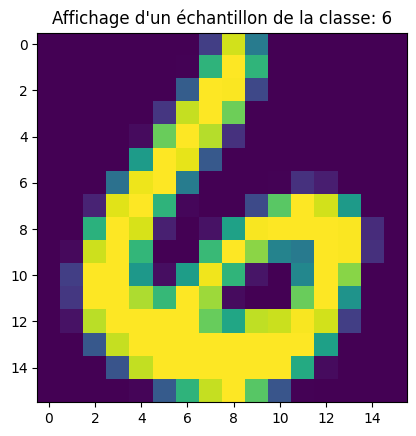

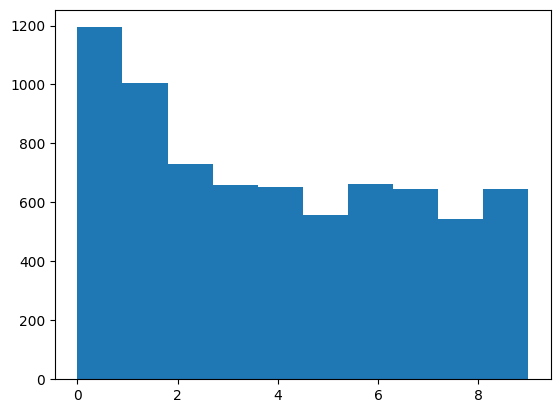

In [ ]:
X,Y = load('data/usps_train.txt')
Xt,Yt = load('data/usps_test.txt')

Y = Y.astype(int)
Y_onehot = np.zeros((Y.size,10));
Y_onehot[np.arange(Y.size),Y]=1
Y_onehot
# affichage d'un échantillon
plt.figure()
index = 0
plt.imshow(X[index].reshape(16,16), interpolation=None)
plt.title('Affichage d\'un échantillon de la classe: '+str(Y[index]))

# étude très rapide des données:
plt.figure()
plt.hist(Y, 10) # histogramme de répartition des 10 classes
plt.show()

In [ ]:
X_ = X.reshape(X.shape[0], X.shape[1], 1)

In [ ]:
np.random.seed(6)
#ini
Mconv1D = Conv1D(3,1,32)
MMaxpool = MaxPool1D(2,2)
MFlatten = Flatten()
MLin1 = Linear(4064,100)
MRelu = ReLU_factor(factor= 0.2)
MLin2 = Linear(100,10) # 10 classes
MSig = Sigmoide()
#ini seq
net = Sequentiel(Mconv1D, MMaxpool, MFlatten, MLin1, MRelu, MLin2,MSig)

#forward
z = net.forward(X_)

l = SMCELoss()
l.forward(Y_onehot, z)

# prediction = argmax
y_pred = np.argmax(logsoftmax(z), axis = 1)
# accu
res = np.where(y_pred == Y, 1, 0).sum()
print("Acc:",res/len(Y))

ValueError: ignored

In [ ]:
nbiter = 200
eps = 0.001
for i in range(nbiter):
  #Back propagation
  net.backward(SMCELoss(), Y_onehot,gradient_step=eps)

  #forward
  z = net.forward(X_)

  # prediction = argmax
  y_pred = np.argmax(logsoftmax(z), axis = 1)
  # accu
  res = np.where(y_pred == Y, 1, 0).sum()
  print(f"Iter {i+1}, Accuracy:",res/len(Y))

In [ ]:
X,Y = load('data/usps_train.txt')
Xt,Yt = load('data/usps_test.txt')
Y = Y.astype(int)
Y_onehot = np.zeros((Y.size,10));
Y_onehot[np.arange(Y.size),Y]=1
X_ = X.reshape(X.shape[0], X.shape[1], 1)
data = np.array([np.array([x,y]).tolist() for x, y in zip(X_,Y_onehot)])

<ipython-input-55-6436dfc2ccb4>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = np.array([np.array([x,y]).tolist() for x, y in zip(X_,Y_onehot)])


In [ ]:
np.random.seed(6)
#ini
Mconv1D = Conv1D(3,1,32)
MMaxpool = MaxPool1D(2,2)
MFlatten = Flatten()
MLin1 = Linear(4064,100)
MRelu = ReLU_factor(factor= 0.2)
MLin2 = Linear(100,10) # 10 classes
MSig = Sigmoide()
#ini seq
net = Sequentiel(Mconv1D, MMaxpool, MFlatten, MLin1, MRelu, MLin2,MSig)

In [ ]:
# SGD
SGD(net, data, SMCELoss(), eps=1e-2, batch_taille=300, nb_iter=100)

z = net.forward(X_)

# prediction = argmax
y_pred = np.argmax(logsoftmax(z), axis = 1)
# accu
res = np.where(y_pred == Y, 1, 0).sum()
print("Acc:",res/len(Y))

<ipython-input-4-3a447770fbb4>:151: RuntimeWarning: overflow encountered in exp
  return  1/(1+np.exp(-X))
<ipython-input-4-3a447770fbb4>:180: RuntimeWarning: overflow encountered in exp
  return  delta * (1/(1+np.exp(-input))) * (1 - (1/(1+np.exp(-input))))


ValueError: ignored